In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import os

### Loading the Data from the Data Folder

In [2]:
labels = {'Hello' : 0, 'How are you': 1, 'Thanks': 2, 'Braai' : 3, 'Pap' : 4}

In [3]:
action_class = []
sequences = []
classes = ['Hello', 'How are you', 'Thanks', 'Braai', 'Pap']
no_sequences = 400
sequence_length = 30

for action in classes:
    for sequence in range(no_sequences):
        window = []
        for frame in range(sequence_length):
            result = np.load(os.path.join('C:\\Users\\Tyron\\Sign_Language_Detection\\SASL_Sign_Language_Detection\\DATA', action, str(sequence), '{}.npy'.format(frame)))
            window.append(result)
        sequences.append(window)
        if action == 'Hello':
                action_class.append(np.array([1, 0, 0, 0, 0]))
        elif action == 'How are you':
                action_class.append(np.array([0, 1, 0, 0, 0]))
        elif action == 'Thanks':
                action_class.append(np.array([0, 0, 1, 0, 0]))
        elif action == 'Braai':
                action_class.append(np.array([0, 0, 0, 1, 0]))
        elif action == 'Pap':
                action_class.append(np.array([0, 0, 0, 0, 1]))

In [4]:
X = np.array(sequences)
Y = np.array(action_class)

In [5]:
X.shape

(2000, 30, 1662)

In [6]:
Y.shape

(2000, 5)

### Creating Training and Testing Sets

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
X_train, X_valid, = train_test_split(X_train, test_size=0.1, random_state=42)
Y_train, Y_valid = train_test_split(Y_train, test_size=0.1, random_state=42)

# Creating our LSTM model

In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
Tensor_Board_2 = tf.keras.callbacks.TensorBoard(log_dir=os.path.join('Logs_2'))

In [10]:
actions = np.array(list(labels.keys()))

In [11]:
LSTM_Model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=256, return_sequences=True, activation='relu', input_shape=(30, 1662)),
    tf.keras.layers.LSTM(units=128, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(units=256, return_sequences=True, activation='relu'),
    tf.keras.layers.LSTM(units=64, return_sequences=False, activation='relu'),
    tf.keras.layers.Dense(units=5 , activation='softmax',)
])

In [12]:
LSTM_Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy'])

In [13]:
LSTM_Model.output

<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense')>

In [14]:
class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, loss):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold
        self.loss = loss

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_categorical_accuracy"]
        acc = logs['categorical_accuracy']
        loss = logs['loss']
        val_loss = logs['val_loss']
        if val_acc >= self.threshold and acc >= self.threshold and loss <= self.loss and val_loss <= self.loss:
            self.model.stop_training = True

In [15]:
my_callback = MyThresholdCallback(threshold=0.95, loss=0.1)
LSTM_Model_Hist = LSTM_Model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid), epochs=1000, callbacks=[my_callback], batch_size=1)

Epoch 1/1000
1620/1620 [==============================] - 201s 122ms/step - loss: 1.5888 - categorical_accuracy: 0.3679 - val_loss: 1.5551 - val_categorical_accuracy: 0.4667
Epoch 2/1000
1620/1620 [==============================] - 191s 118ms/step - loss: 1.3229 - categorical_accuracy: 0.5006 - val_loss: 0.8054 - val_categorical_accuracy: 0.6167
Epoch 3/1000
1620/1620 [==============================] - 184s 113ms/step - loss: 0.6962 - categorical_accuracy: 0.7284 - val_loss: 0.5228 - val_categorical_accuracy: 0.8222
Epoch 4/1000
1620/1620 [==============================] - 185s 114ms/step - loss: 0.5275 - categorical_accuracy: 0.8086 - val_loss: 0.4761 - val_categorical_accuracy: 0.8389
Epoch 5/1000
1620/1620 [==============================] - 184s 113ms/step - loss: 0.3985 - categorical_accuracy: 0.8741 - val_loss: 0.3671 - val_categorical_accuracy: 0.8778
Epoch 6/1000
1620/1620 [==============================] - 185s 114ms/step - loss: 0.3349 - categorical_accuracy: 0.8963 - val_loss

### Saving the Model

LSTM_Model.save('LSTM_Model_Final_2.h5', overwrite=True)

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

In [17]:
model = tf.keras.models.load_model('C:\\Users\\Tyron\\Sign_Language_Detection\\SASL_Sign_Language_Detection\\LSTM_Model_Final_2.h5')

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 256)           1965056   
                                                                 
 lstm_5 (LSTM)               (None, 30, 128)           197120    
                                                                 
 lstm_6 (LSTM)               (None, 30, 256)           394240    
                                                                 
 lstm_7 (LSTM)               (None, 64)                82176     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 2638917 (10.07 MB)
Trainable params: 2638917 (10.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Testing the Model

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
test_predictions = model.predict(X_test)

7/7 [==============================] - 1s 79ms/step


In [62]:
y_pred = []
y_true = []

for prediction in test_predictions:
    arg_max = np.argmax(prediction)
    y_pred.append(arg_max)

for y in Y_test:
    arg_max = np.argmax(y)
    y_true.append(arg_max)

### Confusion Matrix

In [63]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [65]:
conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

In [66]:
conf_matrix

array([[38,  0,  0,  0,  1],
       [ 0, 36,  0,  2,  0],
       [ 0,  0, 41,  0,  0],
       [ 0,  0,  1, 36,  0],
       [ 3,  0,  1,  0, 41]], dtype=int64)

In [68]:
xticks = ['Hello', 'How are you', 'Thanks', 'Braai', 'Pap']
yticks = ['Hello', 'How are you', 'Thanks', 'Braai', 'Pap']

<AxesSubplot: >

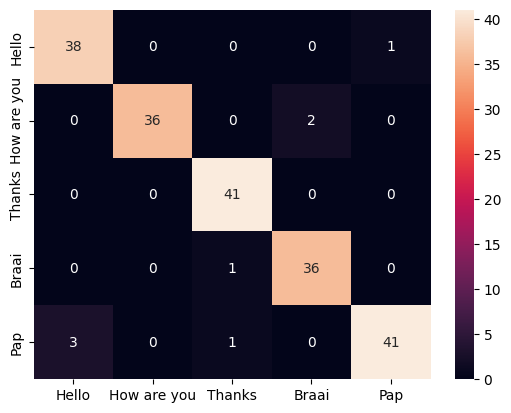

In [70]:
sns.heatmap(data=conf_matrix, xticklabels=xticks, yticklabels=yticks, annot=True)

In [83]:
from sklearn.metrics import accuracy_score

In [85]:
acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)
print('The Accuracy Score of the Model is : {}'.format(acc_score))

The Accuracy Score of the Model is : 0.96
